<a href="https://colab.research.google.com/github/satyamsingh1004/ML/blob/master/Pytorch_CIFAR10_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import copy

print('packages loaded!')

packages loaded!


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

**CIFAR10**:
https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of **60000** **32x32** colour images in **10** classes, with **6000** images per class. There are **50000** training images and **10000** test images. 

In [45]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform_test)

print('Train Size: ' , len(trainset))
print('Test Size: ', len(testset))

Files already downloaded and verified
Files already downloaded and verified
Train Size:  50000
Test Size:  10000


In [0]:
num_classes = 10
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [6]:
dataiter= iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
4


In [0]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize=(batch_size,1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()
  

In [0]:
def show_batch_images(dataloader):
  images,labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img,title=[str(x.item()) for x in labels])

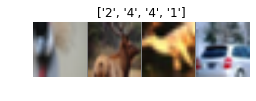

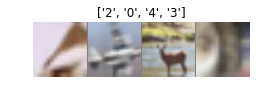

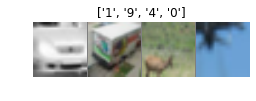

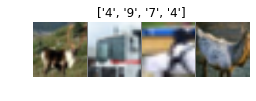

In [9]:
for i in range(4):
  show_batch_images(trainloader)

## **VGG-16**

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [11]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:19<00:00, 28577393.58it/s]


In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [22]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [14]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
def evaluation(dataloader,model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

# **ResNet**

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [0]:
resnet = models.resnet18(pretrained=True)

In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
print(resnet)

In [0]:
num_classes = 10
in_features = resnet.fc.in_features

resnet = nn.Sequential(*(list(resnet.children())[:-1]))

resnet.vowel = nn.Sequential(
            nn.Linear(in_features, num_classes),
            nn.LogSoftmax(dim = 1)
        )

resnet.cons = nn.Sequential(
            nn.Linear(in_features, num_classes),
            nn.LogSoftmax(dim = 1)
        )


In [0]:
print(resnet)

In [13]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])
torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [0]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

In [0]:
inception = models.inception_v3()
print(resnet)

In [0]:
class ResNet50Bottom(nn.Module):
    def __init__(self, original_model):
        super(ResNet50Bottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.vowel = nn.Sequential(
            nn.Linear(original_model.fc.in_features, num_classes)
        )
        self.cons = nn.Sequential(
            nn.Linear(original_model.fc.in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        v = self.vowel(x)
        _, max_v = torch.max(v.data, 1)
        #print(max_v)
        c = self.cons(x)
        _, max_c = torch.max(c.data, 1)
        #print(c.shape)
        return v,c   
      

res50_model = models.resnet50(pretrained=True)
final_model = ResNet50Bottom(res50_model)

print(final_model)

#outputs = res50_conv2(inputs)
#outputs.data.shape  # => torch.Size([4, 2048, 7, 7])



In [0]:
for param in final_model.features.parameters():
    param.requires_grad = False

In [0]:
for param in final_model.parameters():
    if param.requires_grad:
        print(param.shape)

In [0]:
final_model = final_model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(final_model.parameters(), lr=0.01)

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        out_v,out_c = final_model(inputs)
        #print(out_v)
        #print(labels)
        loss_v = loss_fn(out_v, labels)
        loss_c= loss_fn(out_c, labels)
        loss = loss_v + loss_c
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, out_v,out_c
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Min loss 4.68
Iteration: 0/3125, Loss: 4.68
Min loss 4.58
Min loss 4.58
Min loss 4.38
Min loss 4.22
Min loss 4.12
Min loss 4.03
Min loss 4.00
Min loss 3.77
Min loss 3.46
Min loss 3.22
Min loss 3.11
Min loss 3.10
Min loss 2.61
Min loss 2.47
Min loss 2.39
Min loss 2.33
Min loss 2.32
Min loss 2.30
Iteration: 100/3125, Loss: 2.99
Min loss 1.82
Min loss 1.81
Min loss 1.52
Min loss 1.31
Iteration: 200/3125, Loss: 2.23
Min loss 1.24
Min loss 1.20
Iteration: 300/3125, Loss: 2.77
Min loss 1.07
Min loss 0.85
Iteration: 400/3125, Loss: 2.31
Min loss 0.80
Iteration: 500/3125, Loss: 2.47
Iteration: 600/3125, Loss: 1.90
Min loss 0.57
Iteration: 700/3125, Loss: 1.69
Iteration: 800/3125, Loss: 1.14
Iteration: 900/3125, Loss: 2.38
Iteration: 1000/3125, Loss: 2.01
Iteration: 1100/3125, Loss: 1.57
Min loss 0.50
Iteration: 1200/3125, Loss: 3.06
Iteration: 1300/3125, Loss: 1.68
Iteration: 1400/3125, Loss: 1.18
Iteration: 1500/3125, Loss: 1.86
Iteration: 1600/3125, Loss: 2.03
Iteration: 1700/3125, Loss: 1.7

In [0]:
def evaluation1(dataloader,model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    v,c = = model(inputs)
    _, pred_v = torch.max(v.data, 1)
    _, pred_c = torch.max(c.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
